# LGG Brain MRI Segmentation — Transfer Learning + Self-Attention (ResNet-U-Net)

This notebook trains a segmentation model on the LGG FLAIR abnormality dataset:
- Patient-level split to prevent leakage
- Transfer learning (ImageNet pretrained ResNet34 encoder)
- Bottleneck self-attention (multi-head attention on deep features)
- Dice + BCE loss, Dice/IoU metrics
- Paper-style plots (global matplotlib styling)

Outputs saved to `/kaggle/working/`.


In [1]:
# If Kaggle already has these, this cell is harmless.
!pip -q install albumentations==1.3.1 opencv-python-headless==4.9.0.80


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 37.0 MB/s eta 0:00:00


In [2]:
!pip -q uninstall -y albumentations opencv-python opencv-python-headless || true


In [3]:
import os, re, glob, random, math, time
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models import resnet34, ResNet34_Weights


In [4]:
import torchvision.transforms.functional as TF

class TorchvisionAugment:
    def __init__(self, train=True):
        self.train = train

    def __call__(self, img, msk):
        # img: numpy HWC uint8, msk: numpy HW uint8(0/1)
        img = TF.to_tensor(img)          # float32, [0,1], CHW
        msk = torch.from_numpy(msk).unsqueeze(0).float()

        if self.train:
            if torch.rand(1).item() < 0.5:
                img = TF.hflip(img); msk = TF.hflip(msk)
            if torch.rand(1).item() < 0.2:
                img = TF.vflip(img); msk = TF.vflip(msk)
            # small rotation
            angle = float((torch.rand(1).item() - 0.5) * 24.0)  # [-12, 12]
            img = TF.rotate(img, angle, interpolation=TF.InterpolationMode.BILINEAR)
            msk = TF.rotate(msk, angle, interpolation=TF.InterpolationMode.NEAREST)

        return img, msk


In [5]:
# -------------------------------
# ✅ GLOBAL PAPER-STYLE SETTINGS (as you provided)
# -------------------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "font.size": 12,

    "axes.labelsize": 13,
    "axes.titlesize": 13,
    "axes.linewidth": 1.2,

    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,

    "legend.fontsize": 11,
    "legend.frameon": True,
    "legend.edgecolor": "0.4",

    "grid.linestyle": ":",
    "grid.linewidth": 0.7,
    "grid.alpha": 0.85,
})

def paper_axes(ax):
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle=":", linewidth=0.8)
    ax.grid(True, which="minor", linestyle=":", linewidth=0.5, alpha=0.7)

    for spine in ax.spines.values():
        spine.set_linewidth(1.2)

    ax.tick_params(which="both", direction="in", top=True, right=True)

# -------------------------------
# Reproducibility
# -------------------------------
SEED = 7
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = False  # faster; OK with fixed seed
torch.backends.cudnn.benchmark = True


In [6]:
CFG = {
    "img_size": 256,
    "batch_size": 16,
    "num_workers": 2,
    "epochs": 12,
    "lr": 3e-4,
    "weight_decay": 1e-4,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "use_attention": True,          # ablation knob
    "attn_heads": 8,                # 512 channels / 8 heads works cleanly
    "threshold": 0.5,
}

CFG


{'img_size': 256,
 'batch_size': 16,
 'num_workers': 2,
 'epochs': 12,
 'lr': 0.0003,
 'weight_decay': 0.0001,
 'device': 'cuda',
 'use_attention': True,
 'attn_heads': 8,
 'threshold': 0.5}

1. ## Load dataset index (with safe fallback)

Preferred:
- Load `lgg_master_slices.csv` created by your EDA notebook.

Fallback:
- Rebuild the dataframe directly from `/kaggle/input/**/kaggle_3m`.


In [7]:
KAGGLE_INPUT = Path("/kaggle/input")
candidates = list(KAGGLE_INPUT.glob("**/kaggle_3m"))
print("Found candidates:", [str(p) for p in candidates[:10]])

if len(candidates) == 0:
    raise FileNotFoundError("Could not find 'kaggle_3m' under /kaggle/input. Attach the dataset to this notebook.")

DATA_ROOT = candidates[0]
DATA_ROOT


Found candidates: ['/kaggle/input/datasets/mateuszbuda/lgg-mri-segmentation/kaggle_3m', '/kaggle/input/datasets/mateuszbuda/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m']


PosixPath('/kaggle/input/datasets/mateuszbuda/lgg-mri-segmentation/kaggle_3m')

In [8]:
def to_key(path):
    base = Path(path).name
    if base.endswith("_mask.tif"):
        base = base.replace("_mask.tif", "")
    else:
        base = base.replace(".tif", "")
    return base

def patient_id_from_path(path):
    return Path(path).parent.name

def slice_index_from_key(k):
    m = re.search(r"_(\d+)$", k)
    return int(m.group(1)) if m else np.nan

EDA_CSV = Path("/kaggle/working/eda_outputs/lgg_master_slices.csv")

if EDA_CSV.exists():
    df = pd.read_csv(EDA_CSV)
    print("Loaded:", EDA_CSV, "| rows:", len(df), "| patients:", df["patient_id"].nunique())
else:
    all_tifs = sorted(glob.glob(str(DATA_ROOT / "*" / "*.tif")))
    mask_tifs = sorted([p for p in all_tifs if p.endswith("_mask.tif")])
    img_tifs  = sorted([p for p in all_tifs if not p.endswith("_mask.tif")])

    img_map = {to_key(p): p for p in img_tifs}
    msk_map = {to_key(p): p for p in mask_tifs}
    keys = sorted(set(img_map.keys()) & set(msk_map.keys()))

    df = pd.DataFrame({
        "key": keys,
        "image_path": [img_map[k] for k in keys],
        "mask_path":  [msk_map[k] for k in keys],
    })
    df["patient_id"] = df["image_path"].apply(patient_id_from_path)
    df["slice_idx"] = df["key"].apply(slice_index_from_key)

    print("Built df | rows:", len(df), "| patients:", df["patient_id"].nunique())

df.head()


Built df | rows: 3929 | patients: 110


,key,image_path,mask_path,patient_id,slice_idx
0,TCGA_CS_4941_19960909_1,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,TCGA_CS_4941_19960909,1
1,TCGA_CS_4941_19960909_10,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,TCGA_CS_4941_19960909,10
2,TCGA_CS_4941_19960909_11,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,TCGA_CS_4941_19960909,11
3,TCGA_CS_4941_19960909_12,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,TCGA_CS_4941_19960909,12
4,TCGA_CS_4941_19960909_13,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,/kaggle/input/datasets/mateuszbuda/lgg-mri-seg...,TCGA_CS_4941_19960909,13


In [9]:
if "split" not in df.columns or df["split"].isna().any():
    patients = df["patient_id"].drop_duplicates().tolist()
    rng = np.random.default_rng(SEED)
    rng.shuffle(patients)

    n = len(patients)
    train_pat = set(patients[: int(0.8*n)])
    val_pat   = set(patients[int(0.8*n): int(0.9*n)])
    test_pat  = set(patients[int(0.9*n):])

    def assign_split(pid):
        if pid in train_pat: return "train"
        if pid in val_pat: return "val"
        return "test"

    df["split"] = df["patient_id"].apply(assign_split)

df["split"].value_counts(), df.groupby("split")["patient_id"].nunique()


(split
 train    3068
 test      435
 val       426
 Name: count, dtype: int64,
 split
 test     11
 train    88
 val      11
 Name: patient_id, dtype: int64)

## Dataset + augmentations

Notes:
- Images are 256×256 and stored as 3-channel uint8 (we normalize to [0,1]).
- Masks are binarized to {0,1} and returned as a 1×H×W tensor.


In [10]:
# ✅ Torchvision-based transforms (drop-in replacement for Albumentations)
# This defines train_tfms and val_tfms as callables: (img_np, mask_np) -> (img_t, mask_t)

import torch
import torchvision.transforms.functional as TF

class TorchvisionAugment:
    def __init__(self, train=True):
        self.train = train

    def __call__(self, img, msk):
        # img: numpy HWC uint8, msk: numpy HW uint8 {0,1}
        img_t = TF.to_tensor(img)                      # (3,H,W) float32 in [0,1]
        msk_t = torch.from_numpy(msk).unsqueeze(0).float()  # (1,H,W)

        if self.train:
            if torch.rand(1).item() < 0.5:
                img_t = TF.hflip(img_t); msk_t = TF.hflip(msk_t)
            if torch.rand(1).item() < 0.2:
                img_t = TF.vflip(img_t); msk_t = TF.vflip(msk_t)

            angle = float((torch.rand(1).item() - 0.5) * 24.0)  # [-12, 12]
            img_t = TF.rotate(img_t, angle, interpolation=TF.InterpolationMode.BILINEAR)
            msk_t = TF.rotate(msk_t, angle, interpolation=TF.InterpolationMode.NEAREST)

            # Brightness/contrast (simple, no cv2)
            if torch.rand(1).item() < 0.25:
                b = 0.9 + 0.2 * torch.rand(1).item()   # [0.9,1.1]
                c = 0.9 + 0.2 * torch.rand(1).item()   # [0.9,1.1]
                img_t = TF.adjust_brightness(img_t, b)
                img_t = TF.adjust_contrast(img_t, c)

            # Mild blur (available in newer torchvision; if not, it will raise)
            if torch.rand(1).item() < 0.15:
                try:
                    img_t = TF.gaussian_blur(img_t, kernel_size=[3, 3], sigma=[0.1, 1.2])
                except Exception:
                    pass

        return img_t, msk_t

train_tfms = TorchvisionAugment(train=True)
val_tfms   = TorchvisionAugment(train=False)


In [11]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch

def load_tif(path):
    return np.array(Image.open(path))

def to_mask01(msk):
    # Ensure binary {0,1}, handle possible 3-channel masks
    if msk.ndim == 3:
        m = msk[..., 0]
    else:
        m = msk
    return (m > 0).astype(np.uint8)

class LGGSegDataset(Dataset):
    def __init__(self, df, tfms=None):
        self.df = df.reset_index(drop=True)
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        img = load_tif(r.image_path)           # (H,W,3) uint8 (usually)
        msk = to_mask01(load_tif(r.mask_path)) # (H,W) uint8 {0,1}

        # Ensure 3 channels
        if img.ndim == 2:
            img = np.stack([img, img, img], axis=-1)

        # ✅ TorchvisionAugment path: callable(img_np, mask_np) -> (img_t, mask_t)
        if self.tfms is not None:
            img_t, msk_t = self.tfms(img, msk)     # <- FIX (no keyword args)
            # Ensure mask shape is (1,H,W)
            if msk_t.ndim == 2:
                msk_t = msk_t.unsqueeze(0).float()
            return img_t.float(), msk_t.float()

        # Fallback (no tfms)
        img_t = torch.from_numpy(img).permute(2,0,1).float() / 255.0
        msk_t = torch.from_numpy(msk).unsqueeze(0).float()
        return img_t, msk_t


In [12]:
train_df = df[df["split"]=="train"].copy()
val_df   = df[df["split"]=="val"].copy()
test_df  = df[df["split"]=="test"].copy()

train_ds = LGGSegDataset(train_df, tfms=train_tfms)
val_ds   = LGGSegDataset(val_df, tfms=val_tfms)
test_ds  = LGGSegDataset(test_df, tfms=val_tfms)

train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True,
                          num_workers=CFG["num_workers"], pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False,
                          num_workers=CFG["num_workers"], pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=CFG["batch_size"], shuffle=False,
                          num_workers=CFG["num_workers"], pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)


(3068, 426, 435)

x: torch.Size([16, 3, 256, 256]) torch.float32 y: torch.Size([16, 1, 256, 256]) torch.float32 mask unique: tensor([0., 1.])


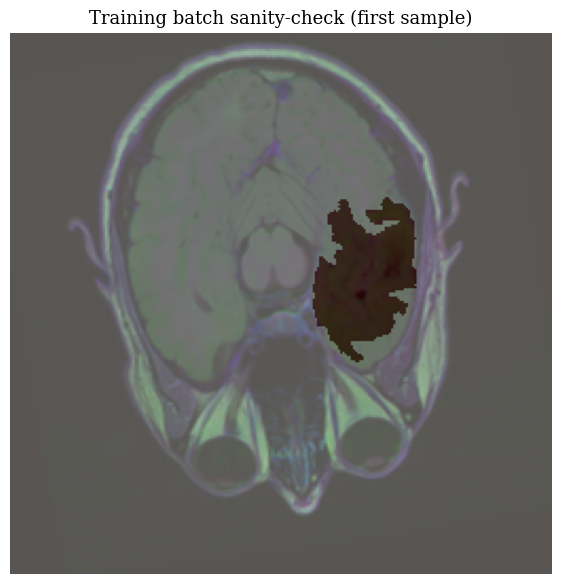

In [13]:
xb, yb = next(iter(train_loader))
print("x:", xb.shape, xb.dtype, "y:", yb.shape, yb.dtype, "mask unique:", torch.unique(yb))

# Plot a few samples (paper style)
fig, ax = plt.subplots(figsize=(13, 6))
paper_axes(ax)
ax.axis("off")
ax.set_title("Training batch sanity-check (first sample)")

img = xb[0].permute(1,2,0).cpu().numpy()
msk = yb[0,0].cpu().numpy()

ax.imshow(np.clip(img, 0, 1))
ax.imshow(msk, alpha=0.35, cmap="Reds")
plt.tight_layout()
plt.show()


## Model: ResNet34 U-Net + bottleneck self-attention

- Encoder: ResNet34 pretrained on ImageNet (transfer learning)
- Bottleneck attention: multi-head self-attention over the 8×8 deep feature tokens
- Decoder: U-Net style upsampling with skip connections


In [14]:
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, p=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=k, padding=p, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class UpBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv1 = ConvBNReLU(out_ch + skip_ch, out_ch)
        self.conv2 = ConvBNReLU(out_ch, out_ch)

    def forward(self, x, skip):
        x = self.up(x)
        # handle any off-by-1 due to rounding (shouldn't happen at 256, but keep safe)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class BottleneckMHSA(nn.Module):
    """
    Multi-head self-attention on deep feature map.
    Operates on (B,C,H,W) -> tokens (B,HW,C) -> MHA -> reshape back, residual + FFN.
    """
    def __init__(self, channels, heads=8, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(channels)
        self.attn = nn.MultiheadAttention(embed_dim=channels, num_heads=heads,
                                          dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(channels)
        self.ffn = nn.Sequential(
            nn.Linear(channels, channels*4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(channels*4, channels),
        )

    def forward(self, x):
        b, c, h, w = x.shape
        tokens = x.permute(0,2,3,1).reshape(b, h*w, c)  # (B,HW,C)

        t = self.norm1(tokens)
        attn_out, _ = self.attn(t, t, t, need_weights=False)
        tokens = tokens + attn_out

        t2 = self.norm2(tokens)
        tokens = tokens + self.ffn(t2)

        x_out = tokens.reshape(b, h, w, c).permute(0,3,1,2)
        return x_out


In [15]:
class ResNet34UNetAttn(nn.Module):
    def __init__(self, pretrained=True, use_attention=True, attn_heads=8):
        super().__init__()
        weights = ResNet34_Weights.IMAGENET1K_V1 if pretrained else None
        self.encoder = resnet34(weights=weights)

        # ResNet stem
        self.conv1 = self.encoder.conv1
        self.bn1   = self.encoder.bn1
        self.relu  = self.encoder.relu
        self.maxp  = self.encoder.maxpool

        # Encoder stages (skip connections)
        self.layer1 = self.encoder.layer1  # 64
        self.layer2 = self.encoder.layer2  # 128
        self.layer3 = self.encoder.layer3  # 256
        self.layer4 = self.encoder.layer4  # 512

        self.use_attention = use_attention
        self.attn = BottleneckMHSA(512, heads=attn_heads) if use_attention else nn.Identity()

        # Decoder
        self.up3 = UpBlock(512, 256, 256)
        self.up2 = UpBlock(256, 128, 128)
        self.up1 = UpBlock(128, 64, 64)

        # Stem skip: after conv1+bn+relu is 64 at 128x128
        self.up0 = UpBlock(64, 64, 64)

        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        x0 = self.relu(self.bn1(self.conv1(x)))  # (B,64,128,128)
        x1 = self.layer1(self.maxp(x0))          # (B,64,64,64)
        x2 = self.layer2(x1)                     # (B,128,32,32)
        x3 = self.layer3(x2)                     # (B,256,16,16)
        x4 = self.layer4(x3)                     # (B,512,8,8)

        # Self-attention bottleneck
        x4 = self.attn(x4)

        # Decoder (upsample + skips)
        d3 = self.up3(x4, x3)                    # (B,256,16,16)
        d2 = self.up2(d3, x2)                    # (B,128,32,32)
        d1 = self.up1(d2, x1)                    # (B,64,64,64)
        d0 = self.up0(d1, x0)                    # (B,64,128,128)

        # Final upsample to 256x256
        d0 = F.interpolate(d0, scale_factor=2, mode="bilinear", align_corners=False)  # (B,64,256,256)

        logits = self.out(d0)                    # (B,1,256,256)
        return logits


In [16]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    losses, dices, ious = [], [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        logits = model(xb)
        loss = total_loss(logits, yb)

        probs = torch.sigmoid(logits)
        probs_bin = (probs > CFG["threshold"]).float()

        losses.append(loss.item())
        dices.append(dice_coeff(probs_bin, yb).item())
        ious.append(iou_coeff(probs_bin, yb).item())

    return {
        "loss": float(np.mean(losses)),
        "dice": float(np.mean(dices)),
        "iou":  float(np.mean(ious)),
    }

def train_one_epoch(model, loader, optimizer, scaler, device):
    model.train()
    losses = []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(device=="cuda")):
            logits = model(xb)
            loss = total_loss(logits, yb)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        losses.append(loss.item())

    return float(np.mean(losses))


In [17]:
def dice_coeff(probs, targets, eps=1e-7):
    # probs, targets: (B,1,H,W) float in [0,1]
    num = 2.0 * (probs * targets).sum(dim=(2,3))
    den = (probs + targets).sum(dim=(2,3)) + eps
    return (num / den).mean()

def iou_coeff(probs, targets, eps=1e-7):
    inter = (probs * targets).sum(dim=(2,3))
    union = (probs + targets - probs*targets).sum(dim=(2,3)) + eps
    return (inter / union).mean()

class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7):
        super().__init__()
        self.eps = eps
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        num = 2.0 * (probs * targets).sum(dim=(2,3))
        den = (probs + targets).sum(dim=(2,3)) + self.eps
        dice = (num / den)
        return 1.0 - dice.mean()

bce = nn.BCEWithLogitsLoss()

def total_loss(logits, targets):
    return 0.6 * bce(logits, targets) + 0.4 * DiceLoss()(logits, targets)


In [18]:
device = CFG["device"]
model = ResNet34UNetAttn(
    pretrained=True,
    use_attention=CFG["use_attention"],
    attn_heads=CFG["attn_heads"],
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])
scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

best_val_dice = -1.0
history = []

save_path = Path("/kaggle/working/best_resnet34_unet_attn.pt")

for epoch in range(1, CFG["epochs"]+1):
    t0 = time.time()
    train_loss = train_one_epoch(model, train_loader, optimizer, scaler, device)
    val_stats = evaluate(model, val_loader, device)

    row = {
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_stats["loss"],
        "val_dice": val_stats["dice"],
        "val_iou": val_stats["iou"],
        "sec": time.time() - t0
    }
    history.append(row)

    if val_stats["dice"] > best_val_dice:
        best_val_dice = val_stats["dice"]
        torch.save({"model": model.state_dict(), "cfg": CFG}, save_path)

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_stats['loss']:.4f} | "
          f"val_dice={val_stats['dice']:.4f} | val_iou={val_stats['iou']:.4f} | best_dice={best_val_dice:.4f}")

history_df = pd.DataFrame(history)
history_df.tail()


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 173MB/s]
/tmp/ipykernel_23/3245350442.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))
/tmp/ipykernel_23/2701682646.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 01 | train_loss=0.5013 | val_loss=0.4299 | val_dice=0.2104 | val_iou=0.1676 | best_dice=0.2104
Epoch 02 | train_loss=0.3825 | val_loss=0.3569 | val_dice=0.2482 | val_iou=0.2118 | best_dice=0.2482
Epoch 03 | train_loss=0.3354 | val_loss=0.3483 | val_dice=0.2305 | val_iou=0.1955 | best_dice=0.2482
Epoch 04 | train_loss=0.3162 | val_loss=0.3216 | val_dice=0.2553 | val_iou=0.2223 | best_dice=0.2553
Epoch 05 | train_loss=0.3051 | val_loss=0.3297 | val_dice=0.2404 | val_iou=0.2016 | best_dice=0.2553
Epoch 06 | train_loss=0.2991 | val_loss=0.3230 | val_dice=0.2427 | val_iou=0.2073 | best_dice=0.2553
Epoch 07 | train_loss=0.3000 | val_loss=0.3103 | val_dice=0.2613 | val_iou=0.2257 | best_dice=0.2613
Epoch 08 | train_loss=0.2951 | val_loss=0.3175 | val_dice=0.2390 | val_iou=0.2062 | best_dice=0.2613
Epoch 09 | train_loss=0.2926 | val_loss=0.3100 | val_dice=0.2558 | val_iou=0.2253 | best_dice=0.2613
Epoch 10 | train_loss=0.2897 | val_loss=0.3084 | val_dice=0.2574 | val_iou=0.2225 | best_di

,epoch,train_loss,val_loss,val_dice,val_iou,sec
7,8,0.295101,0.317527,0.239006,0.206181,21.954161
8,9,0.292596,0.310049,0.255815,0.225287,21.968219
9,10,0.289711,0.308357,0.257436,0.222548,21.965847
10,11,0.290036,0.310290,0.257924,0.224387,22.527360
11,12,0.288917,0.304819,0.267562,0.234858,22.008394


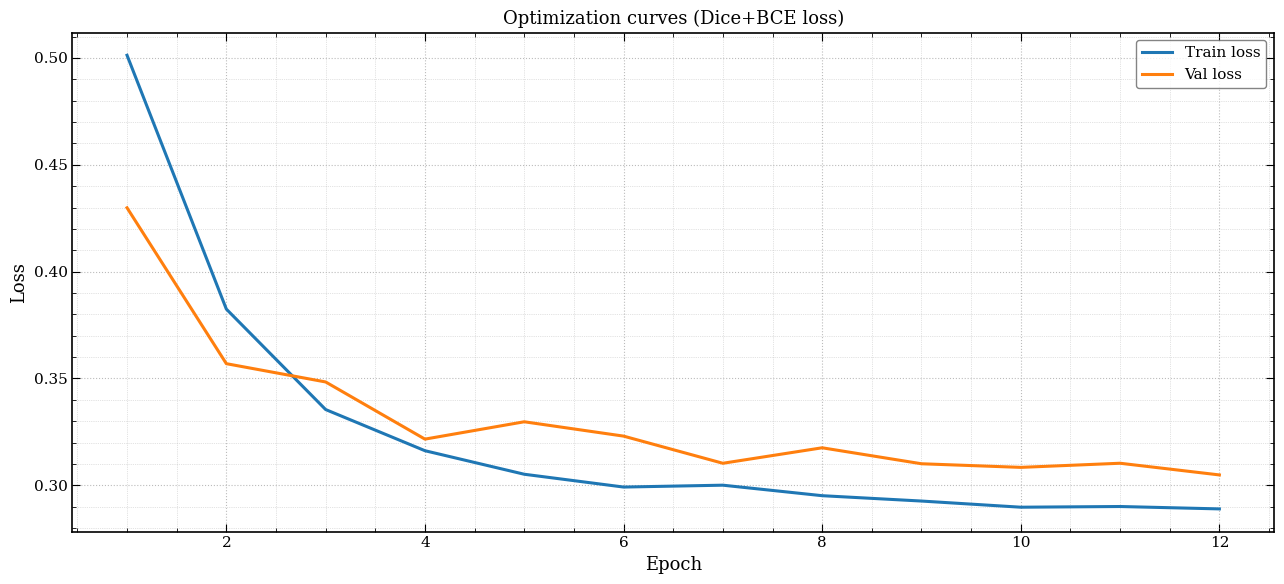

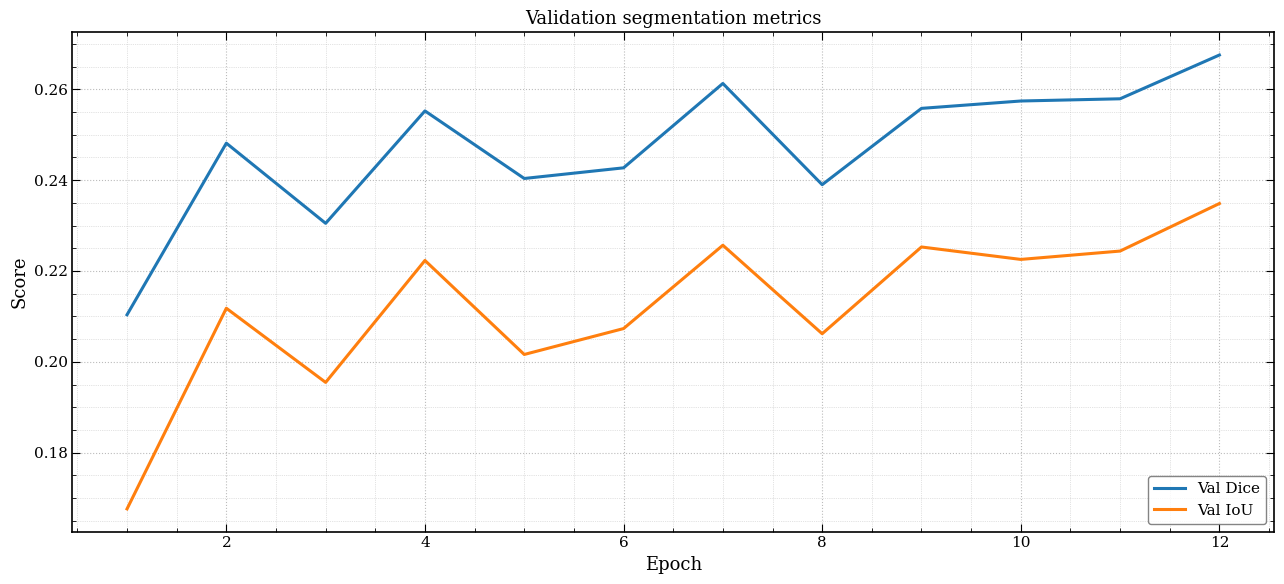

In [19]:
fig, ax = plt.subplots(figsize=(13, 6))
paper_axes(ax)

ax.plot(history_df["epoch"], history_df["train_loss"], lw=2.2, label="Train loss")
ax.plot(history_df["epoch"], history_df["val_loss"], lw=2.2, label="Val loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Optimization curves (Dice+BCE loss)")
ax.legend(loc="upper right")

plt.tight_layout()
plt.savefig("/kaggle/working/curve_loss.png", dpi=300, bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(figsize=(13, 6))
paper_axes(ax)

ax.plot(history_df["epoch"], history_df["val_dice"], lw=2.2, label="Val Dice")
ax.plot(history_df["epoch"], history_df["val_iou"], lw=2.2, label="Val IoU")
ax.set_xlabel("Epoch")
ax.set_ylabel("Score")
ax.set_title("Validation segmentation metrics")
ax.legend(loc="lower right")

plt.tight_layout()
plt.savefig("/kaggle/working/curve_metrics.png", dpi=300, bbox_inches="tight")
plt.show()


## Test evaluation (best checkpoint)


In [20]:
ckpt = torch.load(save_path, map_location=device)
model.load_state_dict(ckpt["model"])

val_stats = evaluate(model, val_loader, device)
test_stats = evaluate(model, test_loader, device)

val_stats, test_stats


({'loss': 0.30481897487684534,
  'dice': 0.26756180905633503,
  'iou': 0.23485778078988748},
 {'loss': 0.3057053280728204,
  'dice': 0.2524738523310849,
  'iou': 0.22326991840132646})

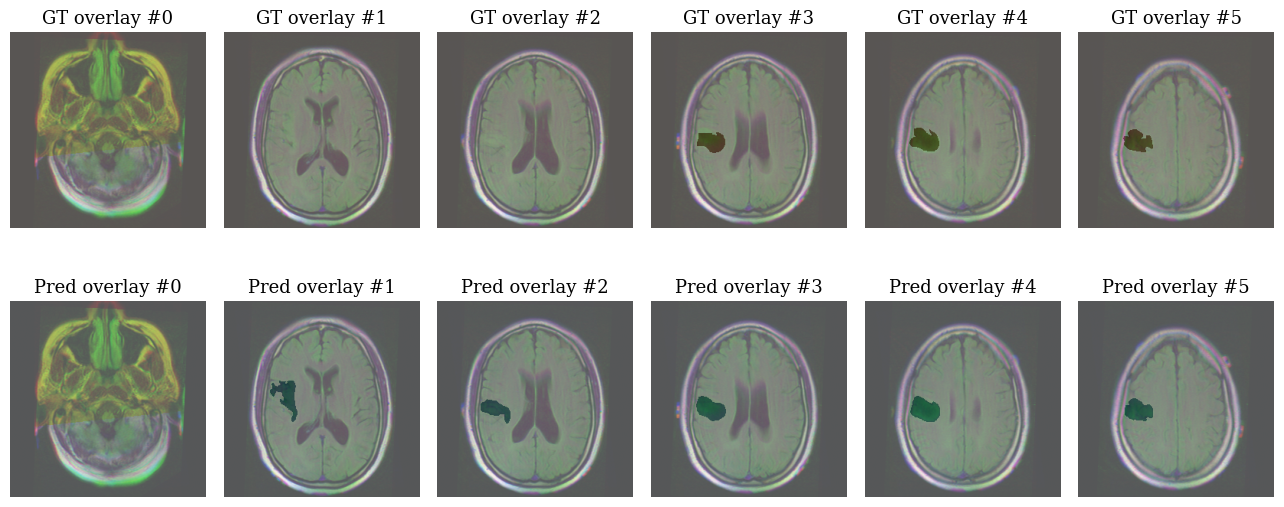

In [21]:
@torch.no_grad()
def visualize_predictions(model, loader, device, n=6):
    model.eval()
    xb, yb = next(iter(loader))
    xb = xb.to(device)
    yb = yb.to(device)

    logits = model(xb)
    probs = torch.sigmoid(logits)
    preds = (probs > CFG["threshold"]).float()

    n = min(n, xb.size(0))
    fig, axes = plt.subplots(2, n, figsize=(13, 6))
    for ax in axes.ravel():
        paper_axes(ax)

    for i in range(n):
        img = xb[i].detach().cpu().permute(1,2,0).numpy()
        gt  = yb[i,0].detach().cpu().numpy()
        pr  = preds[i,0].detach().cpu().numpy()

        axes[0, i].imshow(np.clip(img, 0, 1))
        axes[0, i].imshow(gt, alpha=0.35, cmap="Reds")
        axes[0, i].set_title(f"GT overlay #{i}")
        axes[0, i].axis("off")

        axes[1, i].imshow(np.clip(img, 0, 1))
        axes[1, i].imshow(pr, alpha=0.35, cmap="Blues")
        axes[1, i].set_title(f"Pred overlay #{i}")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.savefig("/kaggle/working/preds_overlay_grid.png", dpi=300, bbox_inches="tight")
    plt.show()

visualize_predictions(model, val_loader, device, n=6)


In [22]:
OUT = Path("/kaggle/working/run_outputs")
OUT.mkdir(parents=True, exist_ok=True)

history_df.to_csv(OUT / "history.csv", index=False)
pd.DataFrame([val_stats]).to_csv(OUT / "val_metrics.csv", index=False)
pd.DataFrame([test_stats]).to_csv(OUT / "test_metrics.csv", index=False)

print("Saved:")
print("-", OUT / "history.csv")
print("-", OUT / "val_metrics.csv")
print("-", OUT / "test_metrics.csv")
print("-", save_path)


Saved:
- /kaggle/working/run_outputs/history.csv
- /kaggle/working/run_outputs/val_metrics.csv
- /kaggle/working/run_outputs/test_metrics.csv
- /kaggle/working/best_resnet34_unet_attn.pt




Next Step
- Ablation: without attention vs with attention (same encoder)
- Transfer learning study: frozen encoder vs full fine-tuning
- Robustness: contrast/noise shifts
- Calibration: threshold sweep + Dice vs threshold curve
- Cross-dataset test (if you attach another Kaggle brain MRI dataset)


# Grad-CAM + GradientSHAP (Captum)

This section generates professional explainability figures:

1) Grad-CAM on the **ResNet34 encoder layer4** (localization of important regions).
2) GradientSHAP (SHAP-style) attributions using **Captum** for a scalar segmentation proxy.

All figures are saved as both PNG and PDF into `/kaggle/working/`.


In [23]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

device = CFG["device"]
ckpt_path = "/kaggle/working/best_resnet34_unet_attn.pt"

ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model"])
model = model.to(device).eval()

print("Loaded:", ckpt_path, "| device:", device)


Loaded: /kaggle/working/best_resnet34_unet_attn.pt | device: cuda


In [24]:
# Prefer slices with non-empty GT mask for cleaner explanations
xb_all, yb_all = next(iter(val_loader))
pos_idx = (yb_all[:, 0].sum(dim=(1,2)) > 0).nonzero(as_tuple=True)[0]

if len(pos_idx) >= 6:
    idx = pos_idx[:6]
else:
    idx = torch.arange(min(6, xb_all.size(0)))

xb = xb_all[idx].to(device)
yb = yb_all[idx].to(device)

with torch.no_grad():
    logits = model(xb)
    probs  = torch.sigmoid(logits)
    preds  = (probs > CFG["threshold"]).float()

print("Batch:", xb.shape, yb.shape, "GT positive count:", int((yb[:,0].sum(dim=(1,2))>0).sum().item()))


Batch: torch.Size([6, 3, 256, 256]) torch.Size([6, 1, 256, 256]) GT positive count: 3


## Grad-CAM (segmentation-aware objective)

Segmentation outputs one logit per pixel, so we need a scalar objective to backpropagate.
We use a stable objective:

**score(x) = mean of top-1% predicted probabilities**  
This focuses the explanation on the most tumor-like pixels while staying differentiable.


In [25]:
class GradCAM:
    def __init__(self, model, target_module):
        self.model = model
        self.target_module = target_module
        self.activations = None
        self.gradients = None
        self.h1 = target_module.register_forward_hook(self._forward_hook)
        self.h2 = target_module.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def close(self):
        self.h1.remove()
        self.h2.remove()

    def _topk_mean(self, probs, frac=0.01):
        # probs: (B,1,H,W)
        b, _, h, w = probs.shape
        k = max(1, int(frac * h * w))
        flat = probs.view(b, -1)
        topk = torch.topk(flat, k=k, dim=1).values
        return topk.mean(dim=1)  # (B,)

    def __call__(self, x):
        self.model.zero_grad(set_to_none=True)
        logits = self.model(x)                 # (B,1,H,W)
        probs  = torch.sigmoid(logits)

        score = self._topk_mean(probs, frac=0.01).sum()   # scalar
        score.backward()

        acts = self.activations                           # (B,C,h,w)
        grads = self.gradients                            # (B,C,h,w)

        w = grads.mean(dim=(2,3), keepdim=True)           # (B,C,1,1)
        cam = (w * acts).sum(dim=1)                       # (B,h,w)
        cam = F.relu(cam).unsqueeze(1)                    # (B,1,h,w)
        cam = F.interpolate(cam, size=x.shape[-2:], mode="bilinear", align_corners=False)[:, 0]

        # Normalize per image
        cam_min = cam.view(cam.size(0), -1).min(dim=1)[0].view(-1,1,1)
        cam_max = cam.view(cam.size(0), -1).max(dim=1)[0].view(-1,1,1)
        cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)
        return cam.detach(), logits.detach()


## Grad-CAM objective for segmentation

Segmentation has many outputs (one logit per pixel), so we must choose a scalar target to backpropagate.
We use a robust, paper-friendly choice:

**Target score = sum of logits inside the predicted tumor region**  
(If predicted mask is empty, fall back to global mean logit.)

This yields stable heatmaps that highlight regions driving the segmentation decision.


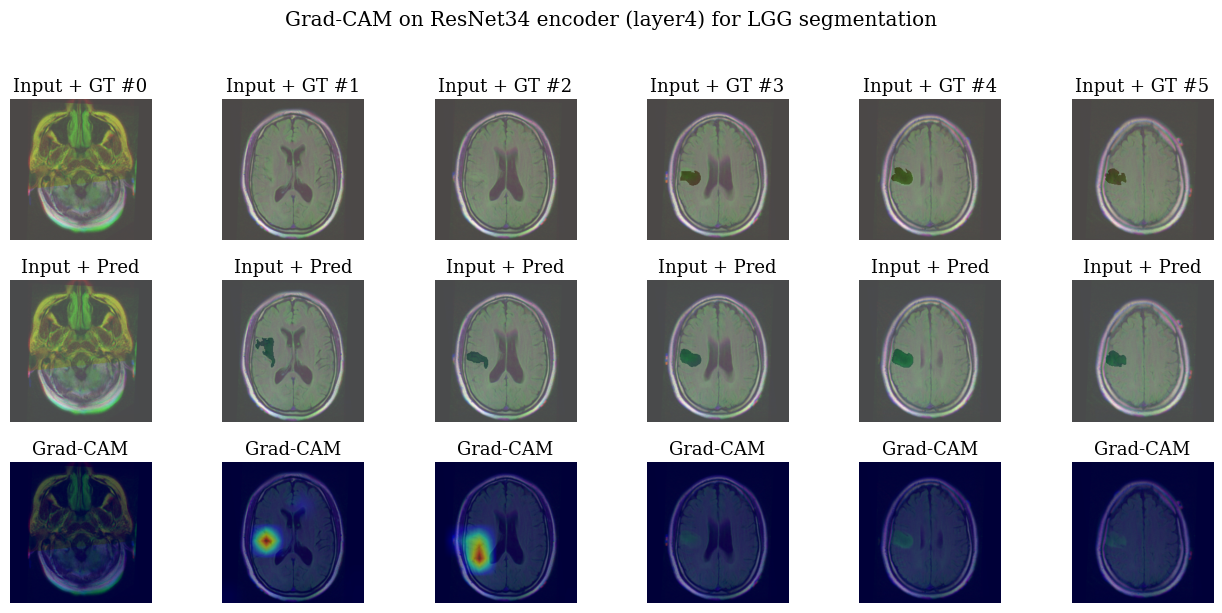

In [26]:
def chw_to_hwc01(x):
    return np.clip(x.detach().cpu().permute(1,2,0).numpy(), 0, 1)

def mask_to_hw(x):
    return x.detach().cpu().numpy()

target_layer = model.layer4[-1].conv2
gc = GradCAM(model, target_layer)

cam, logits_gc = gc(xb)
gc.close()

fig, axes = plt.subplots(3, xb.size(0), figsize=(13, 6))
for ax in axes.ravel():
    paper_axes(ax)

for i in range(xb.size(0)):
    img = chw_to_hwc01(xb[i])
    gt  = mask_to_hw(yb[i,0])
    pr  = mask_to_hw((torch.sigmoid(logits_gc[i,0]) > CFG["threshold"]).float())
    cm  = cam[i].cpu().numpy()

    axes[0, i].imshow(img)
    axes[0, i].imshow(gt, alpha=0.30, cmap="Reds")
    axes[0, i].set_title(f"Input + GT #{i}")
    axes[0, i].axis("off")

    axes[1, i].imshow(img)
    axes[1, i].imshow(pr, alpha=0.30, cmap="Blues")
    axes[1, i].set_title("Input + Pred")
    axes[1, i].axis("off")

    axes[2, i].imshow(img)
    axes[2, i].imshow(cm, alpha=0.45, cmap="jet", vmin=0, vmax=1)
    axes[2, i].set_title("Grad-CAM")
    axes[2, i].axis("off")

fig.suptitle("Grad-CAM on ResNet34 encoder (layer4) for LGG segmentation", y=1.02)
plt.tight_layout()
plt.savefig("/kaggle/working/fig_gradcam_panel.png", dpi=300, bbox_inches="tight")
plt.savefig("/kaggle/working/fig_gradcam_panel.pdf", dpi=300, bbox_inches="tight")
plt.show()


## GradientSHAP (Captum): SHAP-style attributions without NumPy downgrade

The SHAP Python package fails to import on this runtime due to NumPy 2.x incompatibilities.
Instead, we use Captum's **GradientShap**, which approximates SHAP values for differentiable PyTorch models.

We explain a scalar proxy derived from segmentation:
**tumor_score(x) = mean of top-1% predicted probabilities**.


In [27]:
!pip -q install captum==0.7.0

from captum.attr import GradientShap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.7 MB/s eta 0:00:00


In [28]:
import torch.nn as nn

class SegToTumorScore(nn.Module):
    def __init__(self, seg_model, top_frac=0.01):
        super().__init__()
        self.seg_model = seg_model
        self.top_frac = top_frac

    def forward(self, x):
        # x: (B,3,H,W)
        logits = self.seg_model(x)          # (B,1,H,W)
        probs  = torch.sigmoid(logits)      # (B,1,H,W)

        b, _, h, w = probs.shape
        k = max(1, int(self.top_frac * h * w))

        flat = probs.view(b, -1)
        topk = torch.topk(flat, k=k, dim=1).values
        score = topk.mean(dim=1)            # (B,)
        return score

score_model = SegToTumorScore(model, top_frac=0.01).to(device).eval()


In [29]:
@torch.no_grad()
def get_background(loader, n=8):
    xs = []
    for xb_bg, _ in loader:
        xs.append(xb_bg)
        if torch.cat(xs, dim=0).size(0) >= n:
            break
    return torch.cat(xs, dim=0)[:n]

bg = get_background(train_loader, n=8).to(device)

# For speed + clean visuals, compute attributions at 128×128
ATTR_SIZE = 128
xb_ds = F.interpolate(xb, size=(ATTR_SIZE, ATTR_SIZE), mode="bilinear", align_corners=False)
bg_ds = F.interpolate(bg, size=(ATTR_SIZE, ATTR_SIZE), mode="bilinear", align_corners=False)

gs = GradientShap(score_model)

# stdevs adds noise for the expectation (typical GradientSHAP usage)
attr = gs.attribute(
    inputs=xb_ds,
    baselines=bg_ds,
    n_samples=40,
    stdevs=0.05
)  # (B,3,H,W)

print("Attributions:", attr.shape, attr.dtype)


Attributions: torch.Size([6, 3, 128, 128]) torch.float32


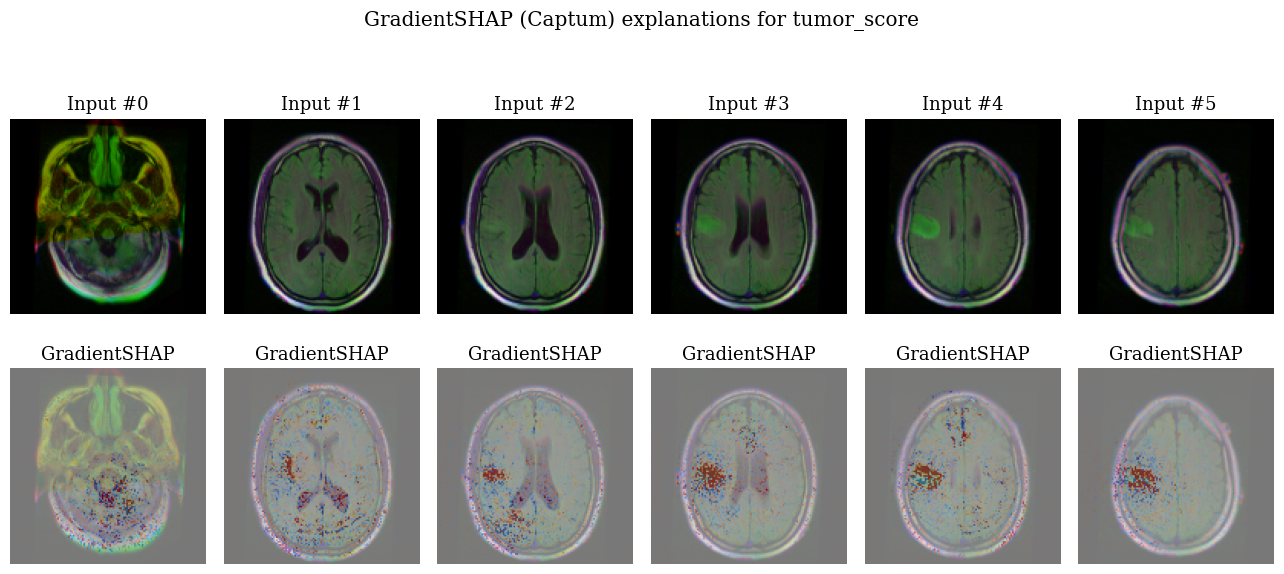

In [30]:
def attr_to_heat(attr_chw):
    # Convert (3,H,W) -> (H,W), signed attribution magnitude
    a = attr_chw.detach().cpu().numpy()
    a = a.mean(axis=0)  # average over channels
    # Normalize robustly for visualization
    p = np.percentile(np.abs(a), 99.0) + 1e-8
    a = np.clip(a / p, -1, 1)
    return a

fig, axes = plt.subplots(2, xb_ds.size(0), figsize=(13, 6))
for ax in axes.ravel():
    paper_axes(ax)

for i in range(xb_ds.size(0)):
    img = np.clip(xb_ds[i].detach().cpu().permute(1,2,0).numpy(), 0, 1)
    heat = attr_to_heat(attr[i])

    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Input #{i}")
    axes[0, i].axis("off")

    axes[1, i].imshow(img)
    axes[1, i].imshow(heat, cmap="coolwarm", alpha=0.55, vmin=-1, vmax=1)
    axes[1, i].set_title("GradientSHAP")
    axes[1, i].axis("off")

fig.suptitle("GradientSHAP (Captum) explanations for tumor_score", y=1.02)
plt.tight_layout()
plt.savefig("/kaggle/working/fig_gradientshap_panel.png", dpi=300, bbox_inches="tight")
plt.savefig("/kaggle/working/fig_gradientshap_panel.pdf", dpi=300, bbox_inches="tight")
plt.show()


In [31]:
# Metric: fraction of positive attribution mass that lies inside the GT mask
# (computed on downsampled masks to match attribution resolution)

yb_ds = F.interpolate(yb, size=(ATTR_SIZE, ATTR_SIZE), mode="nearest")  # (B,1,H,W)

inside_fracs = []
for i in range(xb_ds.size(0)):
    heat = attr_to_heat(attr[i])
    heat_pos = np.maximum(heat, 0.0)

    gt = yb_ds[i,0].detach().cpu().numpy()
    inside = (heat_pos * gt).sum()
    total  = heat_pos.sum() + 1e-8
    inside_fracs.append(float(inside / total))

inside_fracs = np.array(inside_fracs)
print("Attribution inside-GT fraction (per image):", np.round(inside_fracs, 3))
print("Mean ± std:", float(inside_fracs.mean()), float(inside_fracs.std()))


Attribution inside-GT fraction (per image): [0.    0.    0.    0.159 0.143 0.202]
Mean ± std: 0.08407640953858693 0.08594250947098198


- **Grad-CAM:** We generate Grad-CAM maps from the final convolutional layer of the ResNet34 encoder (layer4) using a segmentation-aware scalar objective based on the mean of the top-1% predicted probabilities.
- **GradientSHAP:** We compute GradientSHAP (Captum) attributions for the same scalar objective to estimate pixel contributions to predicted tumor burden.
